In [10]:
from keras import layers
import keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dropout, Layer
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [11]:


# # # Load BERT models from TensorFlow Hub
# bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# # Example input text
# text_input = ["This is a test sentence for BERT model."]

# # Preprocess the input text
# preprocessed_text = bert_preprocess(text_input)

# # Encode the preprocessed text
# outputs = bert_encoder(preprocessed_text)

# # Extract the pooled_output (used for classification tasks)
# pooled_output = outputs["pooled_output"]

# print("Pooled Output:", pooled_output.shape)

In [12]:
import os, re, time, pickle, collections, importlib, datetime, torch, nltk, pandas as pd, numpy as np, random
from chardet import detect
from tqdm import tqdm
from collections import defaultdict, Counter
from wordebd import WORDEBD
from vocab import Vocab, Vectors
from munch import Munch
from cnnlstmseq import CNNLSTMseq
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
import torch.nn as nn
from torch.nn import MaxPool2d
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from model import batch_graphify, LSTMModel,MaskedEdgeAttention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import  BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Concatenate, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.python.keras.backend as K

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
key=False

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [14]:
dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"

In [15]:
def processed_data(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
    return data

In [16]:
SEED = 42

class CNNFeatureExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size, filters, kernel_sizes, dropout):
        super(CNNFeatureExtractor, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, out_channels=filters, kernel_size=K) for K in kernel_sizes])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * filters, output_size)
        self.feature_dim = output_size

    def init_pretrained_embeddings_from_numpy(self, pretrained_word_vectors):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        self.embedding.weight.requires_grad = False

    def forward(self, x, umask):
        if len(x.size()) == 2:  # Check if x has only 2 dimensions
            num_utt, num_words = x.size()
            batch = 1
        else:
            num_utt, batch, num_words = x.size()

        x = x.type(torch.LongTensor)
        x = x.view(-1, num_words)  # Flatten to (num_utt * batch, num_words)
        torch.manual_seed(SEED)
        emb = self.embedding(x)  # Embed (num_utt * batch, num_words) -> (num_utt * batch, num_words, embedding_dim)
        emb = emb.transpose(-2, -1).contiguous()  # (num_utt * batch, num_words, embedding_dim) -> (num_utt * batch, embedding_dim, num_words)

        convoluted = [F.relu(conv(emb)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convoluted]
        concated = torch.cat(pooled, 1)
        features = F.relu(self.fc(self.dropout(concated)))  # Apply dropout and fully connected layer
        features = features.view(num_utt, batch, -1)  # Reshape back to (num_utt, batch, feature_dim)

        mask = umask.unsqueeze(-1).type(torch.FloatTensor)  # (batch, num_utt) -> (batch, num_utt, 1)
        mask = mask.transpose(0, 1)  # (batch, num_utt, 1) -> (num_utt, batch, 1)
        mask = mask.repeat(1, 1, self.feature_dim)  # (num_utt, batch, 1) -> (num_utt, batch, feature_dim)
        features = features * mask  # Apply mask

        return features

In [17]:
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

In [18]:
def load_pretrained_glove():
    print("Loading GloVe...")
    glv_vector = {}
    f = open('embed/glove/glove.840B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float')
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    print("Completed loading pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]

def _read_words(data, convmode=None):
    '''    
    Count the occurrences of all words
    @param convmode: str, None for non conversational scope, 'naive' for classic or naive approach, 'conv' for conversation depth into account (one additional dim and nested values)
    @param data: list of examples
    @return words: list of words (with duplicates)
    '''    
    words = []
    if convmode is None:
        for example in data:
            words += example.split()
    return words

def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges

def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [19]:
# df = pd.read_csv('data/DatasetPreparation/X_train.csv', encoding='shift_jis')

# # Print the column names
# print(df.columns)

# columns_to_use = df.columns[1:]


In [20]:
MAX_PADDING = 100
def x_value(data1, data2):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(data2['Utterance'].values)
    x = tokenizer.texts_to_sequences(data1['Utterance'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    return x

def prev_utt_generator(x):
    shape = x.shape 
    zeros = shape[1]
    zero_array = np.zeros((1, zeros))
    array = np.concatenate((zero_array, x))
    req_array = array[:-1]
    return req_array

In [21]:
X_train = pd.read_csv('data/' + dataset_path + '/train_sent_emo_dya.csv', encoding='shift_jis')
X_test = pd.read_csv('data/' + dataset_path+ '/test_sent_emo_dya.csv', encoding='utf-8')
X_dev = pd.read_csv('data/' + dataset_path + '/dev_sent_emo_dya.csv', encoding='utf-8')


# Display the first three rows
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

# Define features to drop
drop_features = list(X_train.columns[6:]) 

# Create DataFrame for target labels
y_train = pd.DataFrame()
y_test = pd.DataFrame()
y_dev = pd.DataFrame()

y_train["Emotion"] = X_train["Emotion"].copy()
y_test["Emotion"] = X_test["Emotion"].copy()
y_dev["Emotion"] = X_dev["Emotion"].copy()

y_train["Dialogue_ID"] = X_train["Dialogue_ID"].copy()
y_test["Dialogue_ID"] = X_test["Dialogue_ID"].copy()
y_dev["Dialogue_ID"] = X_dev["Dialogue_ID"].copy()



# Drop features from X_train DataFrame
X_train = X_train.drop(drop_features, axis=1)
X_train["Utterance"] = processed_data(X_train["Utterance"]) 
x_train = x_value(X_train, X_train)

X_test = X_test.drop(drop_features, axis=1)
X_test["Utterance"] = processed_data(X_test["Utterance"])
x_test = x_value(X_test, X_train)

X_dev = X_dev.drop(drop_features, axis=1)
X_dev["Utterance"] = processed_data(X_dev["Utterance"])
x_dev = x_value(X_dev, X_train)

(12840, 12)
(3400, 12)
(1462, 12)


In [22]:
# x_train_prev = prev_utt_generator(x_train)
# x_dev_prev = prev_utt_generator(x_dev)
# x_test_prev = prev_utt_generator(x_test)

#### Try the CNN version

In [23]:
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(x_train) # 43,731
MAX_LENGTH = 100

EMBED_SIZE = 256 # arbitary
UNIQUE_DA = 5

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE+1, 
                      output_dim=EMBED_SIZE, 
                      input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)

bn_0 = BatchNormalization()(conv_0)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPooling2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPooling2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPooling2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
merged_1 = Concatenate(axis=-1)([maxpool_0, maxpool_1, maxpool_2])

reshape_1 = Reshape((192,), input_shape=(1,1,192))(merged_1)

output = Dense(7, activation='softmax')(reshape_1)

model = Model(inputs=[inputs], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 256)     3287296     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 256, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 98, 1, 64)    49216       ['reshape[0][0]']                
                                                                                              

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='auto', 
                               patience=3, 
                               verbose=1)

In [25]:
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/label_decoder.pkl")

if not(checkFile1 and checkFile2):
    labels = sorted(set(y_train.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/' + dataset_path + '/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/' + dataset_path + '/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/' + dataset_path +'/label_encoder.pkl', 'rb')
    file2 = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [26]:
# Check if the file already exists
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/labels_train.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/labels_test.pkl")
checkFile3 = os.path.isfile("data/dump/" + dataset_path + "/labels_dev.pkl")

if not (checkFile1 or checkFile2 or checkFile3):
    pickle.dump(X_train["Emotion"], open('data/dump/' + dataset_path + '/labels_train.pkl', 'wb'))
    pickle.dump(X_test["Emotion"], open('data/dump/' + dataset_path + '/labels_test.pkl', 'wb'))
    pickle.dump(X_dev["Emotion"], open('data/dump/' + dataset_path + '/labels_dev.pkl', 'wb'))

In [27]:
encoder = LabelEncoder()
# Encode training labels
y_train['Label'] = encoder.fit_transform(y_train['Emotion'])
y_train_encoded = to_categorical(y_train['Label'], num_classes=7)

# Encode development labels
y_dev['Label'] = encoder.transform(y_dev['Emotion'])
y_dev_encoded = to_categorical(y_dev['Label'], num_classes=7)

# Encode test labels
y_test['Label'] = encoder.transform(y_test['Emotion'])
y_test_encoded = to_categorical(y_test['Label'], num_classes=7)

In [28]:
hist = model.fit(x_train, y_train_encoded, 
                 epochs=20, 
                 batch_size=32, 
                 verbose=1,
                 callbacks=[early_stopping],
                 validation_data=(x_dev, y_dev_encoded))

Epoch 1/20
402/402 [==============================] - 29s 71ms/step - loss: 1.3833 - accuracy: 0.5470 - val_loss: 1.6140 - val_accuracy: 0.4371
Epoch 2/20
402/402 [==============================] - 30s 74ms/step - loss: 0.5031 - accuracy: 0.8350 - val_loss: 1.8187 - val_accuracy: 0.3967
Epoch 3/20
402/402 [==============================] - 29s 71ms/step - loss: 0.2948 - accuracy: 0.9030 - val_loss: 2.1602 - val_accuracy: 0.4302
Epoch 4/20
402/402 [==============================] - 30s 75ms/step - loss: 0.2307 - accuracy: 0.9222 - val_loss: 2.3512 - val_accuracy: 0.4186
Epoch 4: early stopping


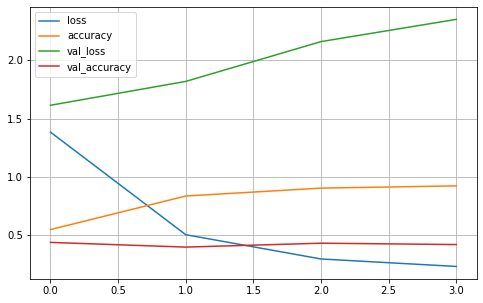

In [29]:
def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()

plot(hist)

In [30]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[  52    9   20   78  310   17   30]
 [   5    5    2   16   57    4   10]
 [   7    2    3    9   35    2    2]
 [  27    7   13  171  248   13   16]
 [  97   15   60  229 1123   47   44]
 [  28    5   14   25  139   37   15]
 [  23    7   19   33  161    9  100]]


In [31]:
f1_per_emotion = f1_score(y_test, y_pred, average=None)
print("F1 score for each emotion:")
for idx, score in enumerate(f1_per_emotion):
    print(f"Emotion {idx}: {score:.4f}")


F1 score for each emotion:
Emotion 0: 0.1377
Emotion 1: 0.0671
Emotion 2: 0.0314
Emotion 3: 0.3239
Emotion 4: 0.6090
Emotion 5: 0.1888
Emotion 6: 0.3515


In [32]:
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.24420160221697104
F1 score(micro) 0.4385294117647059


In [33]:
# Classification report (includes F1 score for each class, precision, recall, and support)
target_names = list(labelDecoder.values())  # Assuming labelDecoder is defined
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

       anger     0.2176    0.1008    0.1377       516
     disgust     0.1000    0.0505    0.0671        99
        fear     0.0229    0.0500    0.0314        60
         joy     0.3048    0.3455    0.3239       495
     neutral     0.5417    0.6954    0.6090      1615
     sadness     0.2868    0.1407    0.1888       263
    surprise     0.4608    0.2841    0.3515       352

    accuracy                         0.4385      3400
   macro avg     0.2764    0.2381    0.2442      3400
weighted avg     0.4079    0.4385    0.4108      3400



In [34]:
df_predictions = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_pred
})


file_name = f"data/dump/{dataset_path}/CNNBiLSTM_data_for_classifier/CNN_predictedTest.pkl"
directory = os.path.dirname(file_name)
if not os.path.exists(directory):
    os.makedirs(directory)
    
with open(file_name, 'wb') as file:
    pickle.dump(df_predictions, file)

#### TODO Get the predicted label of saved in csv

#### Trying the BERT version

In [49]:
x_train = X_train["Utterance"].to_numpy()
x_train = np.asarray(x_train).astype(str)
y_train_encoded = np.asarray(y_train_encoded).astype('float32')

x_test = X_test["Utterance"].to_numpy()
x_test = np.asarray(x_test).astype(str)
y_test_encoded = np.asarray(y_test_encoded).astype('float32')

x_dev = X_dev["Utterance"].to_numpy()
x_dev = np.asarray(x_dev).astype(str)
y_val_encoded = np.asarray(y_dev_encoded).astype('float32')

In [50]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [51]:
embed_dim = 128
num_heads = 3
ff_dim = 32

x_train_rv = X_test["Utterance"].ravel()
x_dev_rv = X_dev["Utterance"].ravel()

C:\Users\edayo\AppData\Local\Temp\ipykernel_15060\2871278467.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x_train_rv = X_test["Utterance"].ravel()
C:\Users\edayo\AppData\Local\Temp\ipykernel_15060\2871278467.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x_dev_rv = X_dev["Utterance"].ravel()


In [61]:
text_input = Input(shape=(), dtype=tf.string, name='Text')
preprocess_text = bert_preprocess(text_input)
encode_output = bert_encoder(preprocess_text)['encoder_outputs'][11]  # Output of the last encoded layer

# BiLSTM layer
bilstm = Bidirectional(LSTM(
    units=64,
    dropout=0.2,
    return_sequences=True))(encode_output)


att = TransformerBlock(embed_dim, num_heads, ff_dim)(bilstm)
pool = GlobalAveragePooling1D()(att)

# Output layer
output = Dense(7, activation='softmax')(pool)

# Define the model
model = Model(inputs=text_input, outputs=output)

model=keras.Model(text_input,output)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               mode='auto', 
                                               patience=3, 
                                               verbose=1)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['Text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

In [54]:
print(f"x_train shape: {x_train.shape}")

x_train shape: (12840,)


In [77]:
hist = model.fit(
    x_train, y_train_encoded, 
          epochs=15, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_dev, y_dev_encoded)
                )

Epoch 1/15
402/402 [==============================] - 2959s 7s/step - loss: 1.3449 - accuracy: 0.5229 - val_loss: 1.3462 - val_accuracy: 0.5055
Epoch 2/15
402/402 [==============================] - 3041s 8s/step - loss: 1.2279 - accuracy: 0.5550 - val_loss: 1.3357 - val_accuracy: 0.5007
Epoch 3/15
402/402 [==============================] - 2940s 7s/step - loss: 1.1298 - accuracy: 0.5879 - val_loss: 1.4588 - val_accuracy: 0.4945
Epoch 4/15
402/402 [==============================] - 3010s 7s/step - loss: 0.9927 - accuracy: 0.6447 - val_loss: 1.5401 - val_accuracy: 0.4774
Epoch 4: early stopping


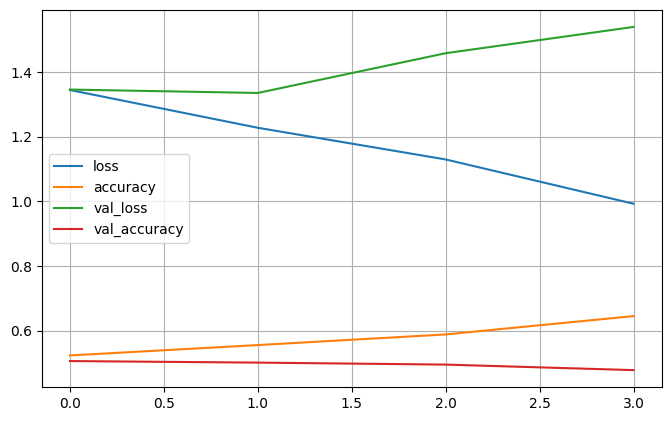

In [78]:
matplotlib.rcParams['figure.dpi'] = 100

def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
plot(hist)

In [79]:
model.evaluate(x_test, y_test_encoded)

107/107 [==============================] - 684s 6s/step - loss: 1.4920 - accuracy: 0.5253


[1.4919867515563965, 0.5252941250801086]

In [80]:
y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[  72   22    3   32  298   14   75]
 [   9   18    2    2   49    9   10]
 [   5    0    5    3   34    5    8]
 [  11    3    0   94  350    8   29]
 [  37   12    1   54 1376   23  112]
 [   8   10    1   11  176   42   15]
 [   6    3    2   21  133    8  179]]


In [73]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 176    0    0   26  222   48   44]
 [  42    0    0    2   31    8   16]
 [  22    0    0    2   20   13    3]
 [  45    0    0   86  288   44   32]
 [ 161    0    0  127 1009  177  141]
 [  54    0    0   18   82   90   19]
 [  56    0    0   18  116   21  141]]


In [81]:
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.3141580324153164
F1 score(micro) 0.5252941176470588


In [ ]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))

rangesDev = find_value_ranges(X_dev["Dialogue_ID"])
print(len(rangesDev))

In [14]:
checkFile = os.path.isfile("embed/glove/" + dataset_path + "/tokenizer.pkl")

## tokenize all sentences ##
if not checkFile:
    all_text = list(X_train["Utterance"])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_text)
    pickle.dump(tokenizer, open('embed/glove/' + dataset_path + '/tokenizer.pkl', 'wb'))
else:
    file1 = open('embed/glove/' + dataset_path + '/tokenizer.pkl', 'rb')
    tokenizer = pickle.load(file1)

In [34]:
## convert the sentences into sequences ##
train_sequence = tokenizer.texts_to_sequences(list(X_train['Utterance']))
dev_sequence = tokenizer.texts_to_sequences(list(X_dev['Utterance']))
test_sequence = tokenizer.texts_to_sequences(list(X_test['Utterance']))

X_train['sentence_length'] = [len(item) for item in train_sequence]
X_dev['sentence_length'] = [len(item) for item in dev_sequence]
X_test['sentence_length'] = [len(item) for item in test_sequence]

In [16]:
max_num_tokens = 250

train_sequence = pad_sequences(train_sequence, maxlen=max_num_tokens, padding='post')
dev_sequence = pad_sequences(dev_sequence, maxlen=max_num_tokens, padding='post')
test_sequence = pad_sequences(test_sequence, maxlen=max_num_tokens, padding='post')

X_train['sequence'] = list(train_sequence)
X_dev['sequence'] = list(dev_sequence)
X_test['sequence'] = list(test_sequence)

In [17]:
X_train.head()

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,sentence_length,sequence
0,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,18,"[455, 1, 32, 3, 940, 443, 28, 18, 3621, 3622, ..."
1,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,6,"[2, 1120, 104, 45, 706, 871, 0, 0, 0, 0, 0, 0,..."
2,That I did. That I did.,Chandler,neutral,neutral,0,2,6,"[9, 1, 76, 9, 1, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,9,"[17, 228, 193, 5, 96, 487, 51, 45, 1971, 0, 0,..."
4,My duties? All right.,Chandler,surprise,positive,0,4,4,"[18, 1971, 29, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
print(X_train['Utterance'][0])

also I was the point person on my company’s transition from the KL-5 to GR-6 system.


In [19]:
checkFile = os.path.isfile("embed/glove/" + dataset_path + "/glv_embedding_matrix.pkl")

if True or not checkFile:
    glv_vector = load_pretrained_glove()
    word_vector_length = len(glv_vector['the'])
    word_index = tokenizer.word_index
    inv_word_index = {v: k for k, v in word_index.items()}
    num_unique_words = len(word_index)
    glv_embedding_matrix = np.zeros((num_unique_words + 1, word_vector_length))
    pickle.dump(glv_embedding_matrix, open('embed/glove/' + dataset_path + '/glv_embedding_matrix.pkl', 'wb'))
else:
    file1 = open('embed/glove/' + dataset_path + '/glv_embedding_matrix.pkl', 'rb')
    glv_embedding_matrix = pickle.load(file1)

Loading GloVe...
Completed loading pretrained GloVe model.


In [20]:
checkFile = os.path.isfile('embed/glove/' + dataset_path + '/pretrained_glv_embedding_matrix')

if True or not checkFile:
    for j in range(1, num_unique_words + 1):
        try:
            glv_embedding_matrix[j] = glv_vector[inv_word_index[j]]
        except KeyError:
            glv_embedding_matrix[j] = np.random.randn(word_vector_length) / 200

    np.ndarray.dump(glv_embedding_matrix, open('embed/glove/' + dataset_path + '/pretrained_glv_embedding_matrix', 'wb'))
    vocab_size = word_vector_length
    print('Done. Completed preprocessing.')
    
else:
#     file1 = open('embed/glove/pretrained_glv_embedding_matrix', 'rb')
#     glv_embedding_matrix = pickle.load(file1)
    glv_embedding_matrix = np.load(open('embed/glove/' + dataset_path + '/pretrained_glv_embedding_matrix', 'rb'), allow_pickle=True)
    vocab_size, embedding_dim = glv_embedding_matrix.shape

Done. Completed preprocessing.


In [21]:
# change D_m into
D_m = 100
D_g = 150
D_p = 150
D_e = 100
D_h = 100
D_a = 100
graph_h=100
seed_everything()

In [22]:
cnn_feat_extractor = CNNFeatureExtractor(vocab_size=vocab_size, embedding_dim=300, output_size=100, filters=50, kernel_sizes=(3, 4, 5), dropout=0.5)
cnn_feat_extractor.init_pretrained_embeddings_from_numpy(glv_embedding_matrix)
lstm = nn.LSTM(input_size=D_m, hidden_size=D_e, num_layers=2, bidirectional=True, dropout=0.5)

<h4> Getting speaker encoder for train set¶

In [23]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))
rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))
rangesDev = find_value_ranges(X_dev["Dialogue_ID"])
print(len(rangesDev))

2160
577
270


In [24]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
encodedSpeakersTrain = []

if True or not checkFile:
    for range_pair in rangesTrain:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_train['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTrain.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_train.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTrain, rangesTrain], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb")
    encodedSpeakersTrain, rangesTrain = pickle.load(file)
    file.close()

C:\Users\edayo\AppData\Local\Temp\ipykernel_9644\2247667134.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_speaker = speaker_per_dialog.replace(speaker_encoder)


<h4> Getting speaker encoder for test set

In [25]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_test.pkl")
encodedSpeakersTest = []

if True or not checkFile:
    for range_pair in rangesTest:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_test['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTest.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_test.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTest, rangesTest], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_test.pkl', "rb")
    encodedSpeakersTest, rangesTest = pickle.load(file)
    file.close()

C:\Users\edayo\AppData\Local\Temp\ipykernel_9644\970745468.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_speaker = speaker_per_dialog.replace(speaker_encoder)


<h4> Getting speaker encoder for val set

In [26]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_dev.pkl")
encodedSpeakersDev = []

if not checkFile:
    for range_pair in rangesDev:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_dev['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersDev.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_dev.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersDev, rangesDev], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_dev.pkl', "rb")
    encodedSpeakersDev, rangesDev = pickle.load(file)
    file.close()

In [27]:
D_m = 100
D_g = 150
D_p = 150
D_e = 200
D_h = 100
D_a = 100
graph_h=100
n_speakers=2
max_seq_len=110
window_past=0
window_future=5
# vocab_size=vocab_size
n_classes=7
listener_state=False
context_attention='general'
dropout=0.5
nodal_attention=False
no_cuda=True
n_relations = 2 * n_speakers ** 2
att_model = MaskedEdgeAttention(D_e, max_seq_len, no_cuda)
nodal_attention=True
edge_type_mapping = {}
for j in range(n_speakers):
    for k in range(n_speakers):
        edge_type_mapping[str(j) + str(k) + '0'] = len(edge_type_mapping)
        edge_type_mapping[str(j) + str(k) + '1'] = len(edge_type_mapping)

<h4> Getting data required for graph processing

In [28]:
OverrideFileChecks = True

In [29]:
class ContextDataset(Dataset):
    def __init__(self, X_set, rangesSet, encodedSpeakersSet):
        self.X_set = X_set
        self.rangesSet = rangesSet
        self.encodedSpeakersSet = encodedSpeakersSet

    def __len__(self):
        return len(self.rangesSet)

    def __getitem__(self, idx):
        startIdx, endIdx = self.rangesSet[idx]
        sequence = self.X_set["sequence"][startIdx:endIdx+1].tolist()
        qmask = self.encodedSpeakersSet[startIdx: endIdx+1]
        return torch.FloatTensor(sequence), qmask

# Define the ContextEncoding function
def ContextEncoding(file_path, dataset):
    all_emotions, all_umask, all_seq_lengths = [], [], []
    all_features, all_edge_index, all_edge_norm, all_edge_type, all_edge_index_lengths = [], [], [], [], []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for textf, qmask in tqdm(dataloader, desc="Encoding Progress", unit="batch"):
        textf = textf.squeeze(0)  # Remove batch dimension (1, utterance_size, embedding_size) -> (utterance_size, embedding_size)
        umask = torch.FloatTensor([[1] * textf.size(0)])  # Adjust to (1, utterance_size)
        lengths = [(umask[j] == 1).nonzero().tolist()[-1][0] + 1 for j in range(len(umask))]
        # print(umask.shape, lengths)
        U = cnn_feat_extractor(textf, umask)
        emotions, hidden = lstm(U)
        all_emotions.append(emotions)
        
        features, edge_index, \
        edge_norm, edge_type, \
        edge_index_lengths = batch_graphify(emotions, 
                                            qmask,
                                            lengths,
                                            window_past,
                                            window_future,
                                            edge_type_mapping,
                                            att_model, 
                                            no_cuda)
        all_umask.append(umask)
        all_seq_lengths.append(lengths)
        all_features.append(features)
        all_edge_index.append(edge_index)
        all_edge_norm.append(edge_norm)
        all_edge_type.append(edge_type)
        all_edge_index_lengths.append(edge_index_lengths)

#     all_emotions = torch.cat(all_emotions, dim=0)  # (total_num_utterances, lstm_hidden_size)
    
    with open(file_path[0], 'wb') as file:
        pickle.dump(all_emotions, file)
        
    with open(file_path[1], 'wb') as file:
        pickle.dump([   all_umask, \
                        all_seq_lengths,
                        all_features, \
                        all_edge_index, \
                        all_edge_norm, \
                        all_edge_type, \
                        all_edge_index_lengths], file)
    
    return all_emotions, all_edge_index, all_edge_norm, all_edge_type, all_edge_index_lengths

# File paths
file_path1 = ['embed/' + dataset_path + '/u_prime_CNNBiLSTM_train.pkl', 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_train.pkl']
file_path2 = ['embed/' + dataset_path + '/u_prime_CNNBiLSTM_test.pkl', 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_test.pkl']
file_path3 = ['embed/' + dataset_path + '/u_prime_CNNBiLSTM_dev.pkl', 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_dev.pkl']

# Check if files exist
checkFile1 = os.path.isfile(file_path1[0])
checkFile2 = os.path.isfile(file_path2[0])
checkFile3 = os.path.isfile(file_path3[0])

if not checkFile1:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersTrain for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])

    trainDataset = ContextDataset(X_train, rangesTrain, oheEncodedSpeakersFlat)
    start_time = time.time()
    
    trainContext, \
     all_edge_index, \
     all_edge_norm, \
     all_edge_type, \
     all_edge_index_lengths = ContextEncoding(file_path1, trainDataset)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode train text")

if not checkFile2:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersTest for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    
    testDataset = ContextDataset(X_test, rangesTest, oheEncodedSpeakersFlat)
    start_time = time.time()
    testContext, _, _, _, _ = ContextEncoding(file_path2, testDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")
    
if not checkFile3:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersDev for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    
    devDataset = ContextDataset(X_dev, rangesDev, oheEncodedSpeakersFlat)
    start_time = time.time()
    devContext, _, _, _, _ = ContextEncoding(file_path3, devDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")

if checkFile1 and checkFile2 and checkFile3:
    with open(file_path1[0], 'rb') as file1:
        trainContext = pickle.load(file1)
    with open(file_path2[0], 'rb') as file2:
        testContext = pickle.load(file2)
    with open(file_path3[0], 'rb') as file3:
        devContext = pickle.load(file3)

In [30]:
trainContext[0].shape

torch.Size([14, 1, 200])

<h4> Visualize utterance embeddnig (u') with T-SNE

In [31]:
# if True:
#     # Assuming trainContext, X_train, and labelDecoder are already defined
#     num_instance = len(X_train["Emotion"])

#     # Calculate the counts for each unique label
#     unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

#     # Print the counts for each unique label
#     for label, count in zip(unique_labels, label_counts):
#         print(f"{labelDecoder[label]}: {count} occurrences")

#     encodedFeaturesFlat = [speaker for dialogue in encodedSpeakersTrain for speaker in dialogue]
#     trainContext = trainContext.squeeze(1)

#     # Convert the tensor to a numpy array for use with sklearn
#     trainContext_np = trainContext.detach().numpy()

#     # Perform PCA
#     pca = PCA(n_components=2)
#     trainContext_pca = pca.fit_transform(trainContext_np)

#     # Perform t-SNE
#     tsne = TSNE(n_components=2, random_state=42, perplexity=30)
#     trainContext_tsne = tsne.fit_transform(trainContext_np)

#     # Plot PCA results with color-coded labels  
#     plt.figure(figsize=(14, 7))

#     plt.subplot(1, 2, 1)
#     for label in unique_labels:
#         indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
#         plt.scatter(trainContext_pca[indices, 0], trainContext_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
#     plt.title('PCA of trainContext with Color-Coded Labels')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#     # Plot t-SNE results with color-coded labels
#     plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
#     for label in unique_labels:
#         indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
#         plt.scatter(trainContext_tsne[indices, 0], trainContext_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
#     plt.title('t-SNE of trainContext with Color-Coded Labels')
#     plt.xlabel('t-SNE Component 1')
#     plt.ylabel('t-SNE Component 2')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.show()

<h4>Visualize node features (pre-h') with T-SNE and PCA

In [32]:
# if True:
#     # Assuming trainContext, X_train, and labelDecoder are already defined
#     num_instance = len(X_train["Emotion"])

#     # Calculate the counts for each unique label
#     unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

#     # Print the counts for each unique label
#     for label, count in zip(unique_labels, label_counts):
#         print(f"{labelDecoder[label]}: {count} occurrences")

#     flattened_features = torch.cat(all_features, dim=0)

#     # Convert the tensor to a numpy array for use with sklearn
#     flattened_features_np = flattened_features.detach().numpy()

#     # Perform PCA
#     pca = PCA(n_components=2)
#     flattened_features_np_pca = pca.fit_transform(flattened_features_np)

#     # Perform t-SNE
#     tsne = TSNE(n_components=2, random_state=42, perplexity=30)
#     flattened_features_tsne = tsne.fit_transform(flattened_features_np)

#     # Plot PCA results with color-coded labels
#     plt.figure(figsize=(14, 7))

#     plt.subplot(1, 2, 1)
#     for label in unique_labels:
#         indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
#         plt.scatter(flattened_features_np_pca[indices, 0], flattened_features_np_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
#     plt.title('PCA of trainContext with Color-Coded Labels')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#     # Plot t-SNE results with color-coded labels
#     plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
#     for label in unique_labels:
#         indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
#         plt.scatter(flattened_features_tsne[indices, 0], flattened_features_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
#     plt.title('t-SNE of trainContext with Color-Coded Labels')
#     plt.xlabel('t-SNE Component 1')
#     plt.ylabel('t-SNE Component 2')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.show()

#### Objective measure on observing howuseful the data representation

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [36]:
trainContext

0     neutral
1     neutral
2     neutral
3     neutral
4    surprise
5     neutral
6     neutral
7     neutral
8     neutral
9     neutral
Name: Emotion, dtype: object

In [51]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

flat_trainContext = flatten_extend(trainContext)
stacked_trainContext = torch.stack(flat_trainContext)

In [52]:
trainNp = stacked_trainContext.squeeze(1).detach().numpy()

In [53]:
kmeans = KMeans(n_clusters=len(set(y_train["Emotion"])))
clusters = kmeans.fit_predict(trainNp)

score = silhouette_score(trainNp, clusters)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.25304386019706726


- Silhouette Score > 0.5: Indicates a good clustering with well-separated clusters.
- Silhouette Score between 0 and 0.5: Indicates overlapping clusters to some degree.
- Silhouette Score < 0: Indicates that samples might have been assigned to the wrong clusters.

In [54]:
from sklearn.metrics import calinski_harabasz_score

In [56]:
kmeans = KMeans(n_clusters=len(set(y_train["Emotion"])))
clusters = kmeans.fit_predict(trainNp)

score = calinski_harabasz_score(trainNp, clusters)
print(f"Calinski-Harabasz Index: {score}")

Calinski-Harabasz Index: 3835.5476772002985


Higher values: Indicate better-defined clusters. There is no strict threshold for "good" scores, as it depends on the specific dataset and context.

In [57]:
from sklearn.metrics import davies_bouldin_score

In [58]:
# Assuming `embeddings` is your BERT/CNN output and `labels` are your true labels
kmeans = KMeans(n_clusters=len(y_train["Emotion"]))
clusters = kmeans.fit_predict(trainNp)

score = davies_bouldin_score(trainNp, clusters)
print(f"Davies-Bouldin Index: {score}")

C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (12832) found smaller than n_clusters (12840). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Davies-Bouldin Index: 2.2036955879278816e-07


- Lower values: Indicate better clustering with well-separated clusters.
- Higher values: Indicate poor clustering with overlapping clusters.